# Fractional Cover

## This notebook is currently under development!

## Notebook Summary

This notebook provides a fractional cover product which can be used to represent land cover. 

We're utilising Landsat 8 on AWS data https://docs.opendata.aws/landsat-pds/readme.html, and have indexed into an instance of the ODC, for more information about ODC please visit our landing page Landing Page.

The basis for this notebook below and the following explanation are from Digital Earth Australia http://geoscienceaustralia.github.io/digitalearthau/notebooks/02_DEA_datasets/Introduction_to_Fractional_Cover.html.

### What is Fractional Cover

Fractional Cover represents the proportion of the land surface that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynethic vegetation (NPV).

The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program (JRSRP) which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions. The fractions were retrieved by inverting multiple linear regression estimates and using synthetic endmembers in a constrained non-negative least squares unmixing model.

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.

### Fractional Cover Bands

Bare Soil (bare ground, rock, disturbed) (BS): - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

Photosythetic Vegetation. (green grass, trees, etc.) (PV): - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

Non-Photosythetic vegetation (litter, dead leaf and branches) (NPV): - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

Unmixing Error (UE): - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components.

The initial instance of this product provides fractional cover of a single L8 image with cloud and water removal. Additional iterations will incorporate a time range for which the median product will be used to reduce the influence of cloud on the product.

Additionally a change product will be produced to allow for areas where changes in land cover have been experienced to be identified. 


### Import required modules

In [2]:
%matplotlib inline
import sys
sys.path.append('/home/jovyan/odc-hub/')
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
from utils_sac.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from utils_sac.createAOI import create_lat_lon
from utils_sac.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_sac.interactive_maps import display_map
import numpy as np



## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:

#set baseline start and end of period
baseline_start_date = '1999-7-1'
baseline_end_date = '1999-8-1'

res = (30)

platform = 'LANDSAT_7'

aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

output_projection = "EPSG:32760"


## Translate inputs

In [5]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)


In [6]:
#create resolution
resolution = (-res, res)

In [7]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-17.590848708679893, -17.488875828028657) 
Lon: (177.62557983398438, 177.77372360229492)


In [8]:

display_map(latitude = lat_extents, longitude = lon_extents)

In [9]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]

def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
    else:
        print("invalid platform")
    return product, measurements 

In [10]:
product, measurement = create_product_measurement(platform)

## Load Data 

In [11]:
query = {
    'longitude': lon_extents,
    'latitude': lat_extents,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
}

In [12]:
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)

In [13]:
#create per scene cloud mask
cloud_mask = landsat_qa_clean_mask(ds, platform)
clearsky_scenes = ds.where(cloud_mask)

In [14]:
print(cloud_mask.values)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  

# ADD IN NEW MASK HERE

#Load in water classification.

water_scenes = dc.load(product="water_classification",
               group_by='solar_day',
              measurements = ["water"],
               **query)
               
#change cloud to no data value
clearsky_scenes = scenes.where(scenes != -9999)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


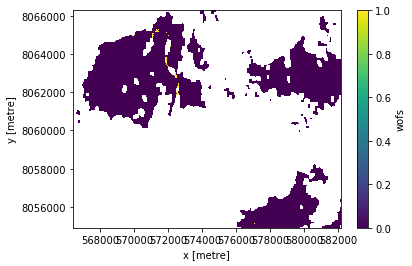

In [15]:
#create per scene water mask
water_classes = wofs_classify(ds, clean_mask=cloud_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
#water_classes.isel(time=4).wofs.plot()

#create mosiac of water mask
water_composite = create_median_mosaic(water_classes)
water_composite.wofs.plot()

In [16]:
#create mosaic
land_composite = create_median_mosaic(clearsky_scenes, clean_mask = cloud_mask, no_data = np.nan)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [31]:
print(land_composite)

<xarray.Dataset>
Dimensions:    (latitude: 379, longitude: 526)
Coordinates:
  * latitude   (latitude) float64 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * longitude  (longitude) float64 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05
Data variables:
    green      (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    red        (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    blue       (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    nir        (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    swir1      (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    swir2      (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    pixel_qa   (latitude, longitude) float64 nan nan nan nan ... nan nan nan


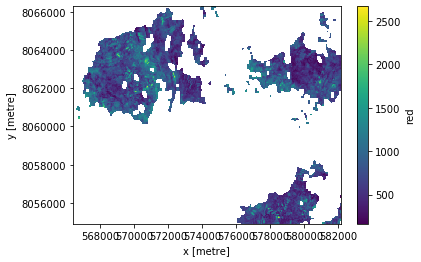

In [17]:
land_composite.red.plot()

In [18]:
booleanMask = land_composite.red == np.nan
print(booleanMask)

<xarray.DataArray 'red' (y: 379, x: 526)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) float64 8.066e+06 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * x        (x) float64 5.664e+05 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05


In [19]:
land_composite = land_composite.rename({"x":"longitude", "y":"latitude"})
#new = new.rename({"x":"longitude", "y":"latitude"})
frac_classes = frac_coverage_classify(land_composite, no_data = np.nan)



In [20]:
print(frac_classes)
####issues here

<xarray.Dataset>
Dimensions:    (latitude: 379, longitude: 526)
Coordinates:
  * latitude   (latitude) float64 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * longitude  (longitude) float64 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05
Data variables:
    bs         (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pv         (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    npv        (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0


In [40]:
frac_cov_test = frac_classes.pv.where(land_composite.red.values != np.nan)

AttributeError: 'DataArray' object has no attribute 'pv'

In [ ]:
print(frac_cov_test)

In [37]:
#frac_cov_test = frac_classes.pv.where(booleanMask != False)

In [38]:
frac_classes = frac_cov_test

In [39]:
print(frac_classes)

<xarray.DataArray 'pv' (latitude: 379, longitude: 526)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * longitude  (longitude) float64 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05


## Plot Fractional Cover

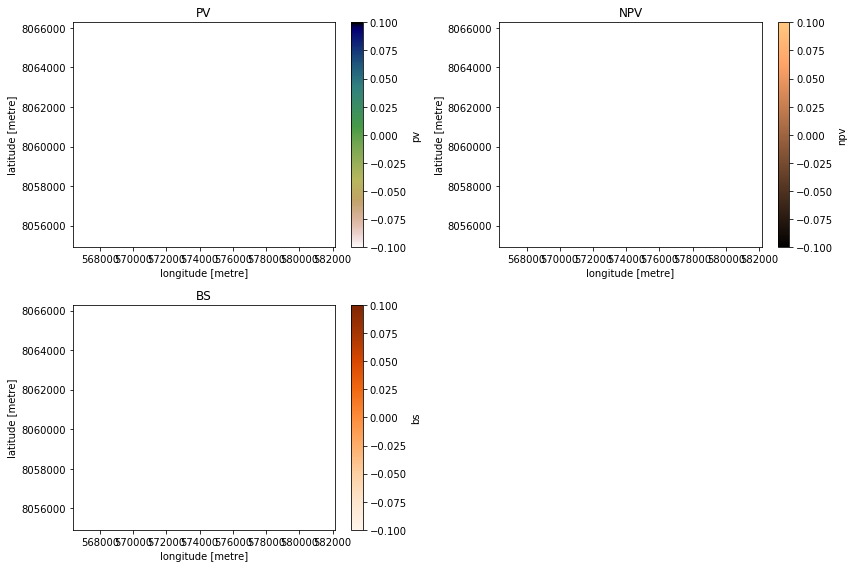

In [34]:
#plot the fractional cover bands. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
frac_classes.pv.plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
frac_classes.bs.plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
frac_classes.npv.plot(cmap='copper')
ax3.set_title('NPV')

plt.tight_layout()
plt.show()

## Create mask layers based on WOfS.

Masks for to remove undesired features from the fractional cover product - clouds, cloud-shadow and water. 

In [24]:
frac_cov_masked = frac_classes.where(water_composite.wofs.values == 0).where(frac_classes != np.nan)


## Create a plot showing FC components.

#Current mask issues in south west corner - with the water mask. 

In [ ]:
#plot the fractional cover bands. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
frac_cov_masked.pv.plot(cmap='gist_earth_r', vmin = 0, vmax = 100)
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
frac_cov_masked.bs.plot(cmap='Oranges', vmin = 0, vmax = 100)
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
frac_cov_masked.npv.plot(cmap='copper', vmin = 0, vmax = 100)
ax3.set_title('NPV')



plt.tight_layout()
plt.show()

In [ ]:
# Plot fractional cover as cloud free RGB image
###work out how to plot this for single image and also how to make a mosaic. 
frac_cov_masked[['bs','pv','npv']].to_array().plot.imshow(
    #col='time',
    figsize=(12, 8),
    vmin=0,
    vmax=100
);